In [1]:
from tqdm import tqdm
from etnn.nn.baseline import create_baseline_model, calc_params
import pandas as pd
import os
from sklearn.metrics import r2_score
from etnn.tools.training import train_epoch, eval_epoch
from etnn import TreeNode
from etnn.nn.layer_framework import LayerManagementFramework
from etnn.routines.run_config import choice_trainloader, choice_loss, choice_optim
import torch
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset_single_node
from etnn.tools.training_tools import ConfigStore, seeding_all
import matplotlib.pyplot as plt

In [2]:
dataset_path = "../../datasets/"
test_perc = 0.3
stability_count = 5
label = "tree-advanced" # although irrelevant

In [3]:
def create_plot(
        df,
        what: str = "r2"
) -> None:
    plt.figure()

    # Plot the initial data
    for config_id in df.config_id.unique():
        # make subdataset for config id
        sub_df = df[df.config_id == config_id]
        # plot train test and val
        for mode in ['train', 'test', 'val']:
            # plot training
            if f"{mode}_{what}" in sub_df.columns:
                plt.plot(sub_df.epoch, sub_df[f"{mode}_{what}"], label=f"{config_id}_{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == "r2":
        plt.ylim(-1, +1)
    plt.legend()
    plt.show()

In [4]:
def run(i, entry, size_elem, normalized, node_type):
    # init default config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=int(entry.params_hidden_dim),
        out_dim=1,
        k=int(entry.params_k),
        dataset=0,
        ds_size=10_000,
        num_gondolas=-1,
        num_part_pg=-1,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=50, # 300, # real: 100
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=5/1000
    )

    # loading dataset
    dataset, df_index = load_pure_ferris_wheel_dataset_single_node(
        node_type=node_type,
        num_elem=size_elem,
        num_to_generate=config.ds_size,
        dataset_path=dataset_path,
        final_label_factor=config.final_label_factor,
        normalize=True if config.dataset == -1 else 0
    )

    if normalized:
        dataset.post_normalize()

    # splitting off test dataset
    generator = torch.Generator().manual_seed(config.seed)
    train_ds, test_ds= random_split(
        dataset,
        [1 - test_perc, test_perc],
        generator=generator
    )

    # loaders
    train_loader = choice_trainloader(config, df_index, train_ds)
    test_loader = DataLoader(test_ds, batch_size=4 * config.batch_size, shuffle=False)

    # define device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # set seed for reproducability
    seeding_all(config.seed)

    # define model
    model = LayerManagementFramework(
        in_dim=config.in_dim,
        tree=TreeNode(node_type, [TreeNode("E", size_elem)]),
        hidden_dim=config.hidden_dim,
        out_dim=config.out_dim,
        k=config.k
    ).to(device)
    print(f"Model params etnn: {calc_params(model)}")

    # learning tools
    criterion = choice_loss(config)
    optimizer = choice_optim(config, model)

    # init score list
    train_r2_list = []
    test_r2_list = []
    train_loss_list = []
    test_loss_list = []

    file_name = f"csvs/single-node_node-type-{node_type}_rank-{i}_post-normalized-{normalized}_n-{size_elem}.csv"
    if os.path.isfile(file_name):
        df = pd.read_csv(file_name)
    else:
        # train for specified number of epochs
        for epoch in tqdm(range(config.num_max_epochs)):
            train_loss, train_true_y, train_pred_y = train_epoch(
                model,
                train_loader,
                optimizer,
                device,
                criterion
            )

            test_loss, test_true_y, test_pred_y = eval_epoch(
                model,
                test_loader,
                device,
                criterion
            )

            # calc r2 score and append
            train_r2_list += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
            test_r2_list += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]
            train_loss_list += [train_loss.item()]
            test_loss_list += [test_loss.item()]

        # REPEAT FOR BASELINE MODEL
        seeding_all(config.seed)
        # %%
        model, _ = create_baseline_model(
            n_params=calc_params(model),
            input_dim=config.in_dim * size_elem,
            n_layer=3,
            output_dim=1
        )
        model = model.to(device)

        optimizer = choice_optim(config, model)

        # train for N epochs
        for epoch in tqdm(range(config.num_max_epochs)):
            train_loss, train_true_y, train_pred_y = train_epoch(
                model,
                train_loader,
                optimizer,
                device,
                criterion
            )

            test_loss, test_true_y, test_pred_y = eval_epoch(
                model,
                test_loader,
                device,
                criterion
            )

            # calc r2 score and append
            train_r2_list += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
            test_r2_list += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]
            train_loss_list += [train_loss.item()]
            test_loss_list += [test_loss.item()]

        df = pd.DataFrame({
            "config_id": ["etnn"]*config.num_max_epochs + ["baseline"]*config.num_max_epochs,
            "epoch": list(range(1, config.num_max_epochs + 1))*2,
            "train_loss": train_loss_list,
            "test_loss": test_loss_list,
            "train_r2": train_r2_list,
            "test_r2": test_r2_list
        })
        df.to_csv(file_name)

    # plotting
    create_plot(df, "r2")
    create_plot(df, "loss")

# S

Rank 1 parameter configuration: Unnamed: 0                                      40
number                                          40
value                                     0.963485
datetime_start          2023-12-20 22:52:39.466096
datetime_complete       2023-12-20 22:54:13.923070
duration                    0 days 00:01:34.456974
params_batcher                               False
params_hidden_dim                              320
params_k                                         3
params_learning_rate                      0.006115
state                                     COMPLETE
Name: 40, dtype: object
Model params etnn: 480321


100%|██████████| 50/50 [03:10<00:00,  3.81s/it]


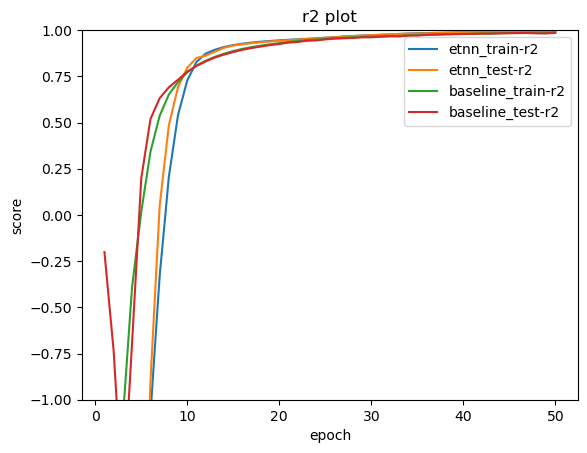

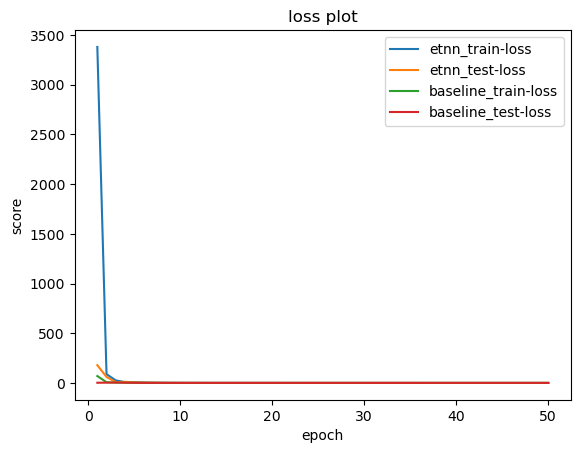

Rank 2 parameter configuration: Unnamed: 0                                      24
number                                          24
value                                     0.960567
datetime_start          2023-12-20 22:25:20.658312
datetime_complete       2023-12-20 22:27:21.613914
duration                    0 days 00:02:00.955602
params_batcher                               False
params_hidden_dim                              256
params_k                                         3
params_learning_rate                      0.005446
state                                     COMPLETE
Name: 24, dtype: object
Model params etnn: 308481


100%|██████████| 50/50 [03:04<00:00,  3.69s/it]


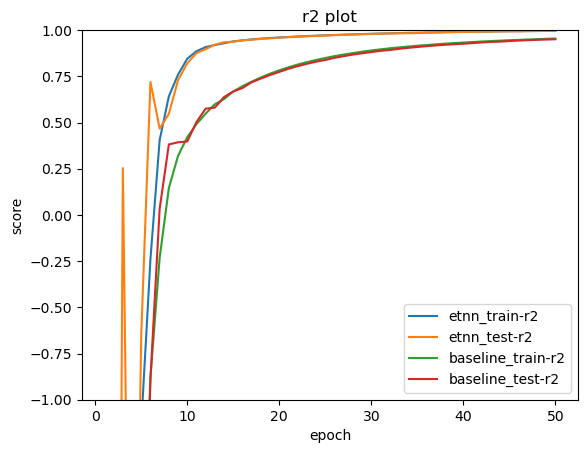

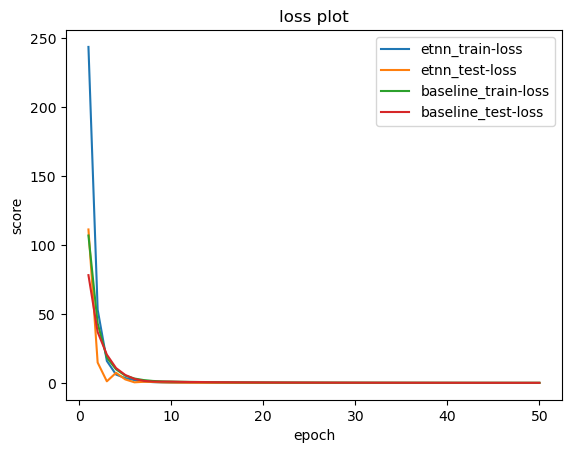

Rank 3 parameter configuration: Unnamed: 0                                      41
number                                          41
value                                     0.955926
datetime_start          2023-12-20 22:54:13.924070
datetime_complete       2023-12-20 22:55:46.147305
duration                    0 days 00:01:32.223235
params_batcher                               False
params_hidden_dim                              320
params_k                                         3
params_learning_rate                      0.009678
state                                     COMPLETE
Name: 41, dtype: object
Model params etnn: 480321


100%|██████████| 50/50 [03:04<00:00,  3.69s/it]


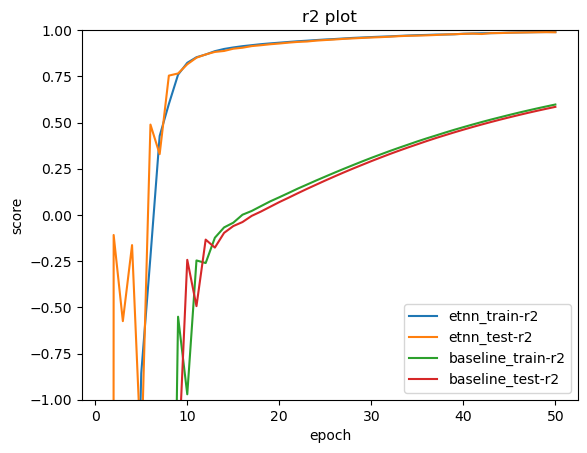

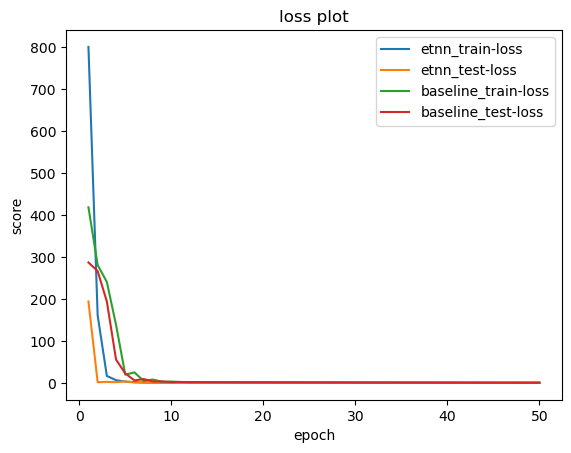

In [5]:
normalized = True
size_elem = 10
node_type = "S"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_post-normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# Q

Rank 1 parameter configuration: Unnamed: 0                                      21
number                                          21
value                                     0.948207
datetime_start          2023-12-20 23:49:14.847425
datetime_complete       2023-12-20 23:51:22.108690
duration                    0 days 00:02:07.261265
params_batcher                               False
params_hidden_dim                              192
params_k                                         3
params_learning_rate                       0.00681
state                                     COMPLETE
Name: 21, dtype: object
Model params etnn: 174529


100%|██████████| 50/50 [03:03<00:00,  3.67s/it]


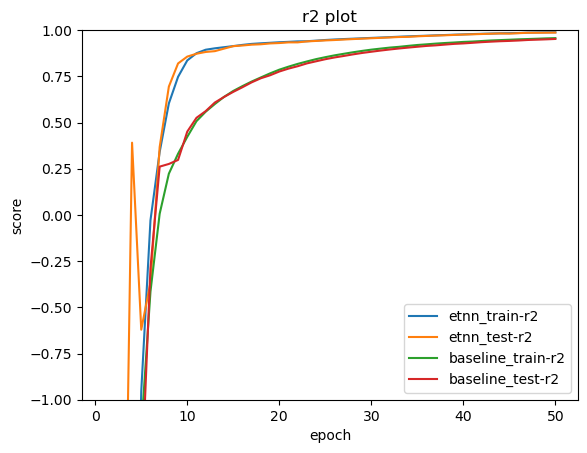

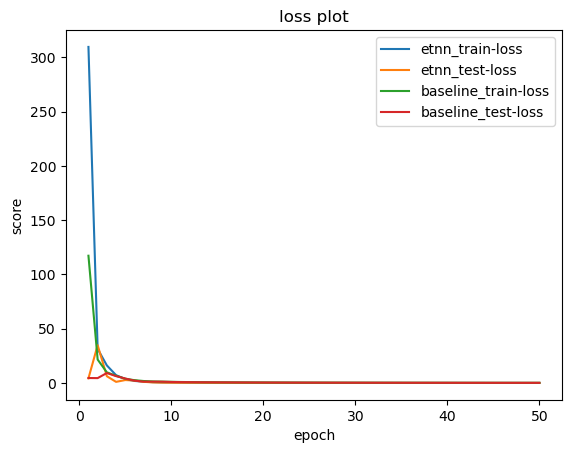

Rank 2 parameter configuration: Unnamed: 0                                      42
number                                          42
value                                     0.946694
datetime_start          2023-12-21 00:33:59.695196
datetime_complete       2023-12-21 00:36:07.931388
duration                    0 days 00:02:08.236192
params_batcher                               False
params_hidden_dim                              160
params_k                                         3
params_learning_rate                       0.00676
state                                     COMPLETE
Name: 42, dtype: object
Model params etnn: 121761


100%|██████████| 50/50 [03:08<00:00,  3.78s/it]


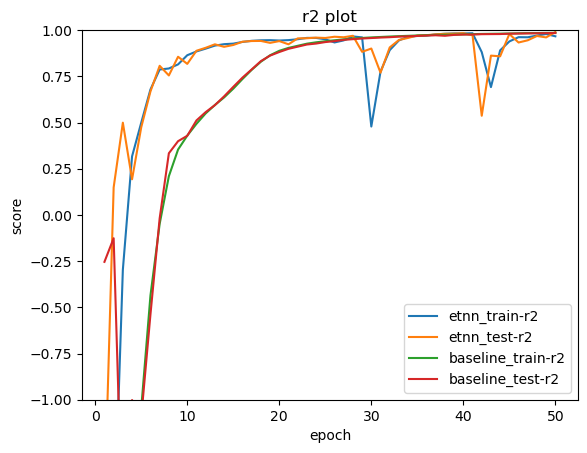

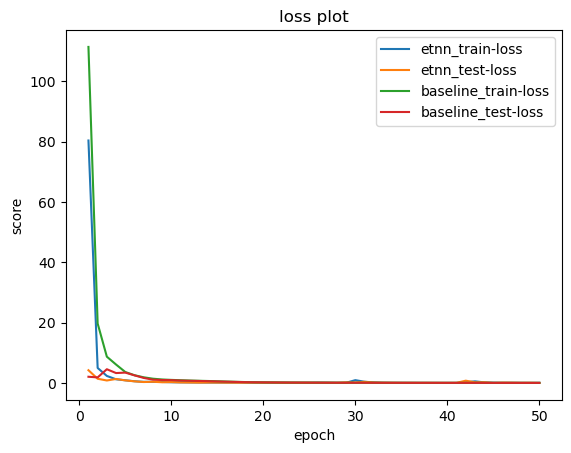

Rank 3 parameter configuration: Unnamed: 0                                      45
number                                          45
value                                      0.94496
datetime_start          2023-12-21 00:40:23.163448
datetime_complete       2023-12-21 00:42:32.074484
duration                    0 days 00:02:08.911036
params_batcher                               False
params_hidden_dim                              144
params_k                                         3
params_learning_rate                       0.00699
state                                     COMPLETE
Name: 45, dtype: object
Model params etnn: 98929


100%|██████████| 50/50 [03:04<00:00,  3.68s/it]


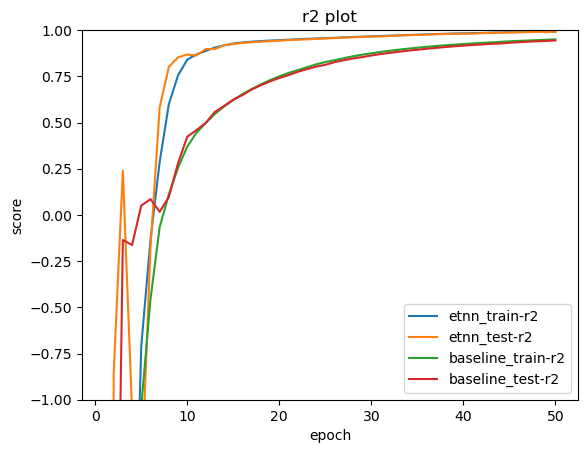

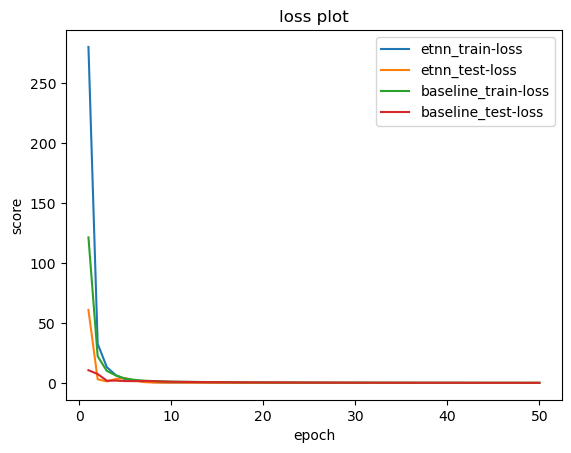

In [6]:
normalized = True
size_elem = 10
node_type = "Q"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_post-normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# C

Rank 1 parameter configuration: Unnamed: 0                                      45
number                                          45
value                                     0.977327
datetime_start          2023-12-21 02:26:34.670630
datetime_complete       2023-12-21 02:28:52.099063
duration                    0 days 00:02:17.428433
params_batcher                               False
params_hidden_dim                              480
params_k                                         4
params_learning_rate                      0.002604
state                                     COMPLETE
Name: 45, dtype: object
Model params etnn: 1306561


100%|██████████| 50/50 [06:23<00:00,  7.68s/it]


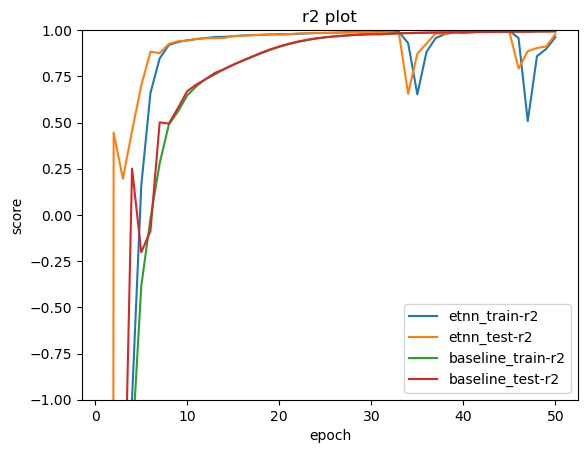

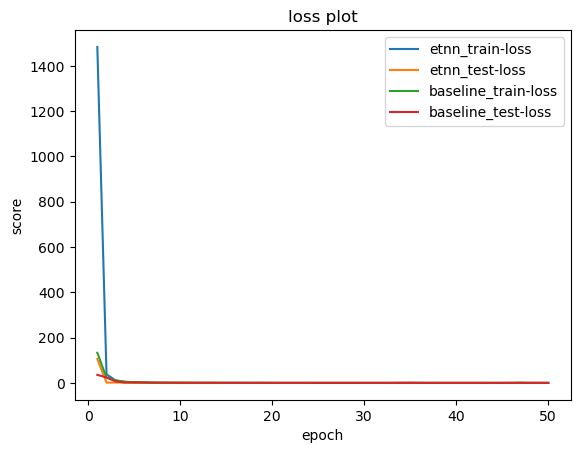

Rank 2 parameter configuration: Unnamed: 0                                      42
number                                          42
value                                     0.972641
datetime_start          2023-12-21 02:20:06.436323
datetime_complete       2023-12-21 02:22:17.361350
duration                    0 days 00:02:10.925027
params_batcher                               False
params_hidden_dim                              416
params_k                                         1
params_learning_rate                      0.007258
state                                     COMPLETE
Name: 42, dtype: object
Model params etnn: 462177


100%|██████████| 50/50 [03:48<00:00,  4.56s/it]


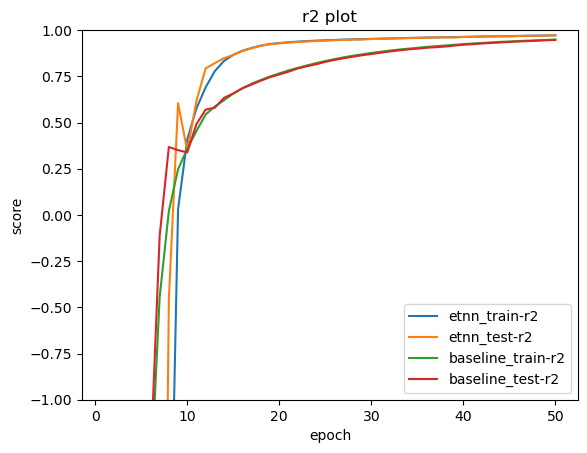

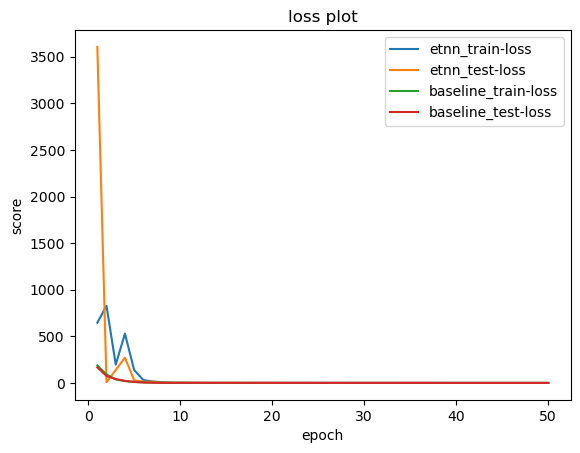

Rank 3 parameter configuration: Unnamed: 0                                      24
number                                          24
value                                     0.970288
datetime_start          2023-12-21 01:42:00.623718
datetime_complete       2023-12-21 01:44:06.660653
duration                    0 days 00:02:06.036935
params_batcher                                True
params_hidden_dim                              304
params_k                                         1
params_learning_rate                      0.005691
state                                     COMPLETE
Name: 24, dtype: object
Model params etnn: 248369


100%|██████████| 50/50 [05:38<00:00,  6.76s/it]


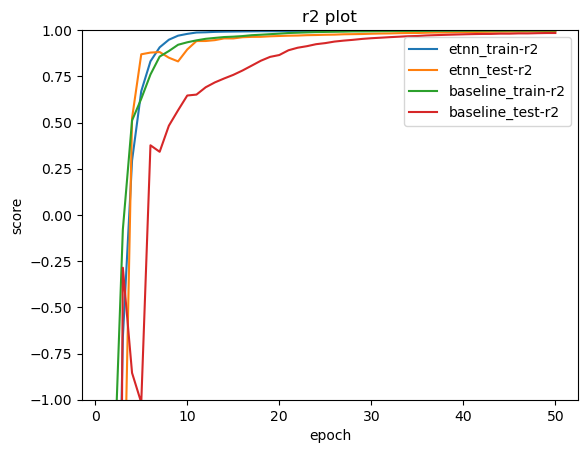

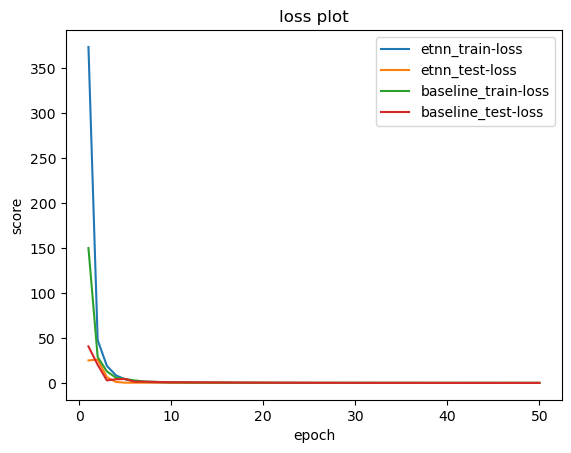

In [7]:
normalized = True
size_elem = 10
node_type = "C"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_post-normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# P

Rank 1 parameter configuration: Unnamed: 0                                      32
number                                          32
value                                     0.974609
datetime_start          2023-12-21 03:58:44.653196
datetime_complete       2023-12-21 04:01:14.721927
duration                    0 days 00:02:30.068731
params_batcher                               False
params_hidden_dim                              432
params_k                                         2
params_learning_rate                      0.004757
state                                     COMPLETE
Name: 32, dtype: object
Model params etnn: 498097


100%|██████████| 50/50 [04:01<00:00,  4.83s/it]


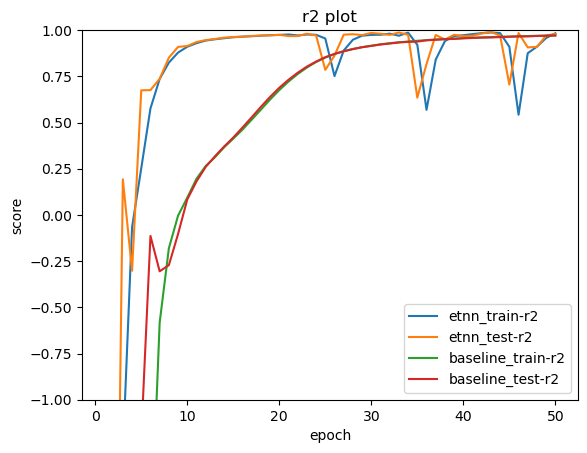

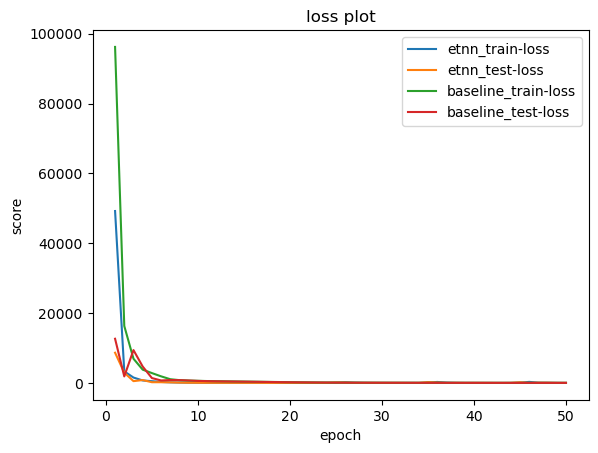

Rank 2 parameter configuration: Unnamed: 0                                      46
number                                          46
value                                     0.970542
datetime_start          2023-12-21 04:25:10.773483
datetime_complete       2023-12-21 04:26:43.206076
duration                    0 days 00:01:32.432593
params_batcher                                True
params_hidden_dim                              400
params_k                                         2
params_learning_rate                      0.005067
state                                     COMPLETE
Name: 46, dtype: object
Model params etnn: 427601


100%|██████████| 50/50 [03:49<00:00,  4.58s/it]


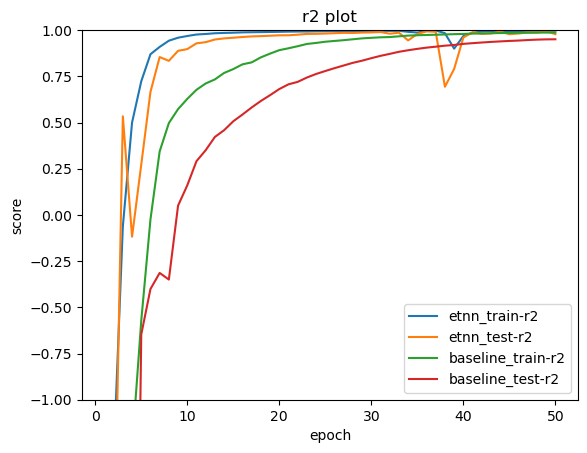

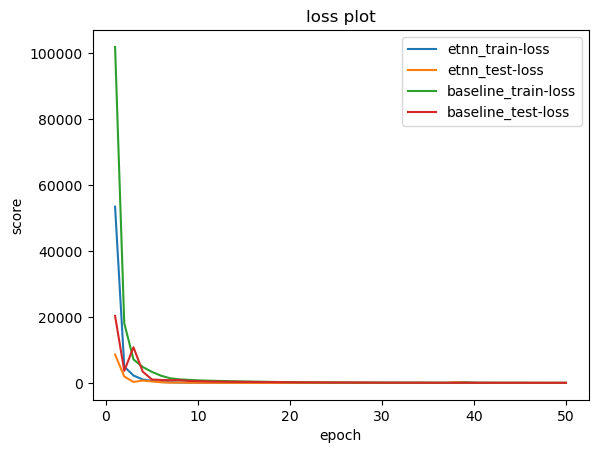

Rank 3 parameter configuration: Unnamed: 0                                      20
number                                          20
value                                     0.968914
datetime_start          2023-12-21 03:28:39.979821
datetime_complete       2023-12-21 03:31:10.421663
duration                    0 days 00:02:30.441842
params_batcher                               False
params_hidden_dim                              304
params_k                                         2
params_learning_rate                      0.009813
state                                     COMPLETE
Name: 20, dtype: object
Model params etnn: 248369


100%|██████████| 50/50 [03:50<00:00,  4.61s/it]


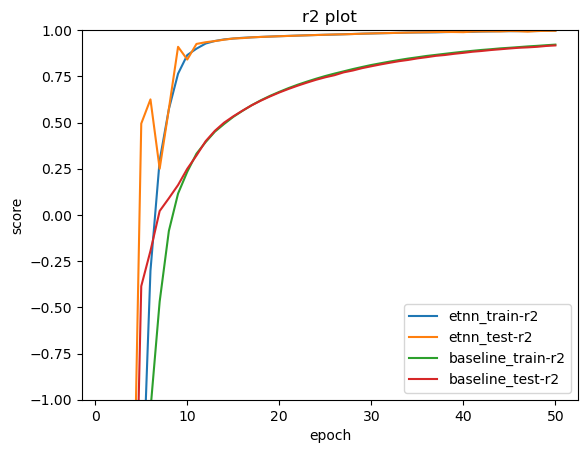

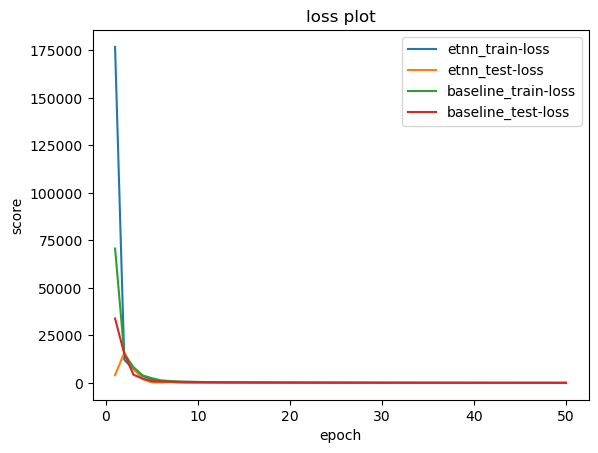

In [5]:
normalized = True
size_elem = 10
node_type = "P"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_post-normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)